# Potential method for calculating Betti numbers

### 1. Input
The first problem we'll be dealing with is how to get an *input* in to the code to begin with. I propose using a class `Graph` from the package **NetworkX** which can create a graph easily and simply with built-in methods such as `add_edge`, `add_node`, and `draw`, and then creating a way to convert this to a matrix over field $\mathbb{F}_2$. This way, we can make it simple to create test graphs without having to create the matrices by hand. This could look like this:

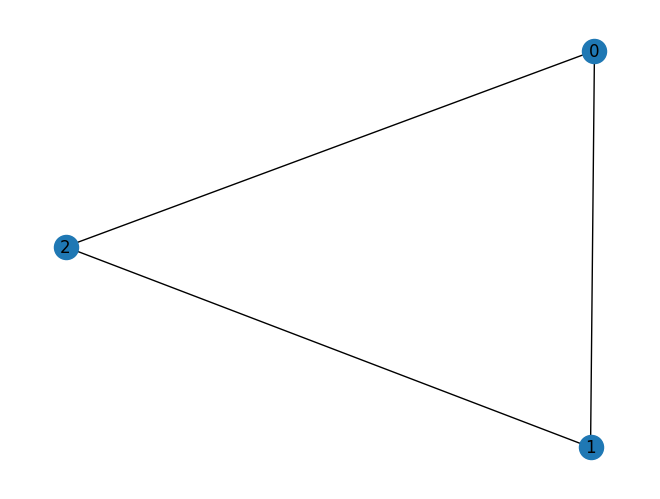

In [62]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import null_space

type Graph = nx.classes.graph.Graph
type Matrix = np.ndarray

G = nx.Graph()
G.add_nodes_from([0, 1, 2])
G.add_edges_from([(0, 1), 
                  (0, 2), 
                  (1, 2)])

nx.draw(G, with_labels=True)
plt.show()

You can even add colors to this representation.

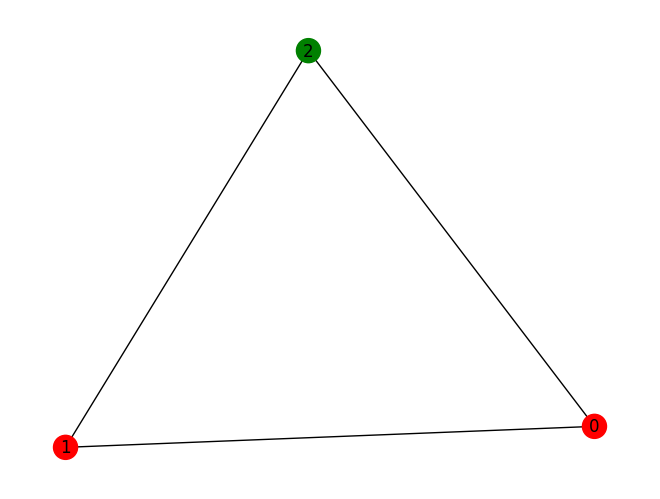

In [63]:
groupA = {0, 1}
groupB = {2}

node_colors = []

for v in G.nodes:
    if v in groupA:
        node_colors.append('red')
    if v in groupB:
        node_colors.append('green')

options = {
    'node_color': node_colors
}

nx.draw(G, with_labels = True, **options)
plt.show()

### 2. Determining Betti numbers


In [64]:
class GraphMatrix:
    """
    Input graph must be a NetworkX graph, and vertices must have form 0, 1, 2, ...
    """
    def __init__(self, graph: Graph):
        self.graph: Graph = graph
        self.vertices: set[int] = set(self.graph.nodes)
        self.edges: list[set[int]] = set(self.graph.edges)
        self.matrix: Matrix = self.graph_matrix(self.graph) % 2
        
    @staticmethod
    def graph_matrix(G: Graph) -> Matrix:
        """
        Static method `graph_matrix` is for taking any NetworkX graph and turning it into a edge space represented by a matrix, or a **NumPy Array**
        """
        g: list[list[int]] = []
        for edge in G.edges:
            vectorized = [0 for _ in list(G.nodes)]
            for v in edge:
                vectorized[v] = 1
            g.append(vectorized)
        return np.array(g).transpose()
    
    def dimension_kernel_boundary_1(self) -> int:
        return len(self.edges) - self.matrix.ndim
        
    
            


In [65]:
graph = GraphMatrix(G)
print(graph.matrix)

[[1 1 0]
 [1 0 1]
 [0 1 1]]


In [66]:
# This will print the dimension of the kernel of the 1-dimensional boundary map, for our graph G that is 1
print(graph.dimension_kernel_boundary_1())

1
